<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Image_Examples/Notebooks/Image_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit Image Examples

### Load Data

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.0 MB/s eta 0:00:00


In [ ]:
import rasterio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gc
from rasterio.warp import reproject, Resampling, calculate_default_transform
import requests
import os
import pandas as pd
import glob
from scipy.ndimage import binary_dilation

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Image_Examples/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]
for file in files:
    os.system(f"wget {file}")
raster_files = glob.glob('*.tif')
raster_files.sort()
print(raster_files)
jpg_files = glob.glob('*.jpg')
jpg_files.sort()
print(jpg_files)

['Mag_Texas.tif', 'TIR.tif', 'saltflats.tif']
['Fossil.jpg', 'goethite.jpg']


### Canny Edge Detector

The image used is of a trilobite fossil from the Virtual Fossil Museum's image gallery. Canny edge detector detects edges in an image. Changing the sigma parameter affects what areas are defined as edges. This tool can be used with fossils to help identify species based on shape. The results show that higher sigma values can outline the species well and could be utilized with a classification workflow.

http://www.fossilmuseum.net/Trilobite-Pictures/Utah/Coosella/Coosella7.htm

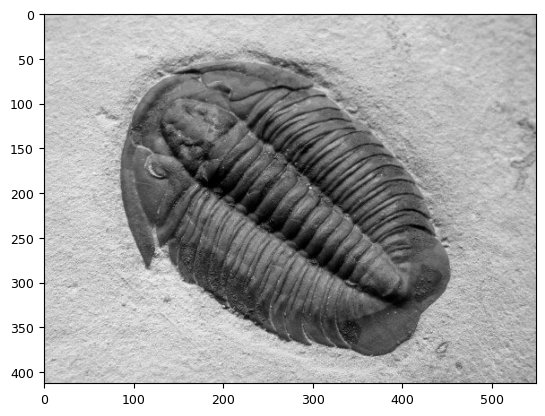

In [64]:
fossil = Image.open(jpg_files[0])
fossil = fossil.convert('L')
fossil_array = np.array(fossil)
image = fossil_array.copy()
plt.imshow(fossil, cmap='gray')
plt.show()

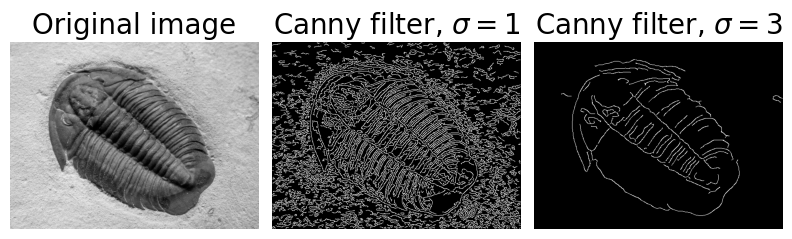

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### Entropy

The image used here is Landsat thermal imagery over the Kilauea volcano during one of it's eruptions on January 1st, 2025. It was taken from the USGS' Earth Explorer site. Entropy is used to single out the active lava pool in the region. Two examples are used with different structuring elements for capturing the entropy. Both do well to delineate the lava pool while also ignoring the surrounding thermal noise. This tool can be used to iterate over imagery with a range of timestamps to determine when the volcano was active and for how long each time.

https://earthexplorer.usgs.gov/

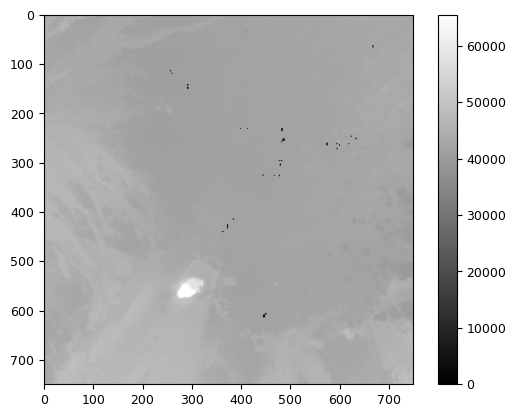

In [70]:
with rasterio.open(raster_files[1]) as src:
    window = rasterio.windows.Window.from_slices((250,1000),(250,1000))
    image = src.read(1, window=window)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show()

/usr/local/lib/python3.11/dist-packages/skimage/filters/rank/generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  image, footprint, out, mask, n_bins = _preprocess_input(


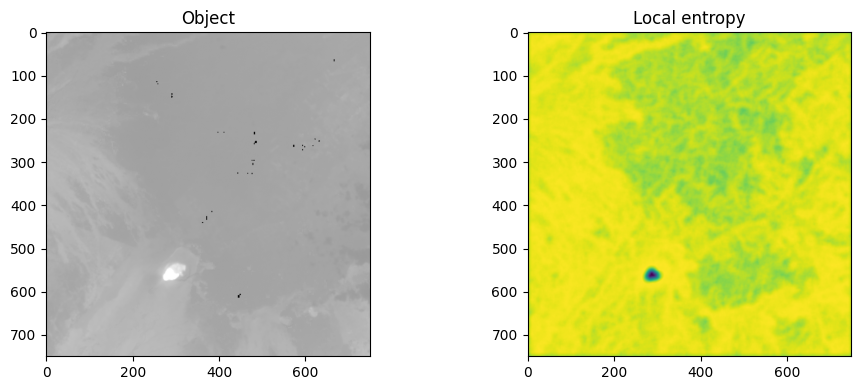

In [ ]:
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

entr_img = entropy(image, disk(10))

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

img0 = ax0.imshow(image, cmap='gray')
ax0.set_title("Object")

ax1.imshow(entr_img, cmap='viridis')
ax1.set_title("Local entropy")

fig.tight_layout()

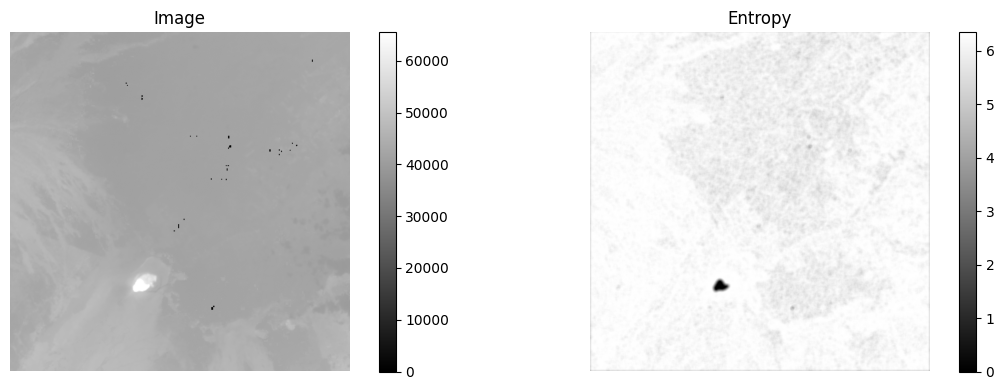

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

### Edge Operators

The image used here is magnetic data over the state of Texas, taken from the USGS' data gallery. Edge operators similar to the first example are used to highlight different structures the magnetic data captures. This can be used to find geologic features of interest.

https://mrdata.usgs.gov/magnetic/

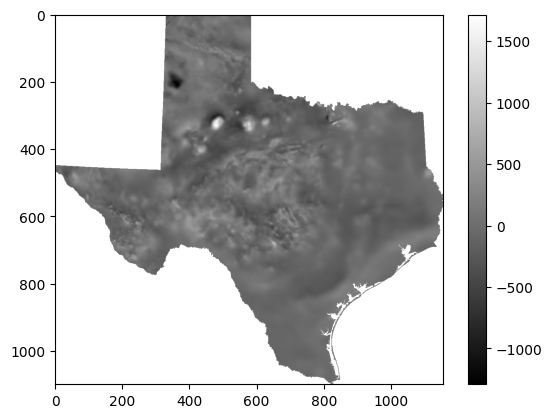

In [ ]:
import matplotlib.colors as colors
with rasterio.open(raster_files[0]) as src:
    image = src.read(1)
    mask = image >= -2000
    mask_zero = image != 0
    mask = np.logical_and(mask, mask_zero)
    masked_image = np.where(mask, image, np.nan)

plt.imshow(masked_image, cmap='gray')
plt.colorbar()
plt.show()

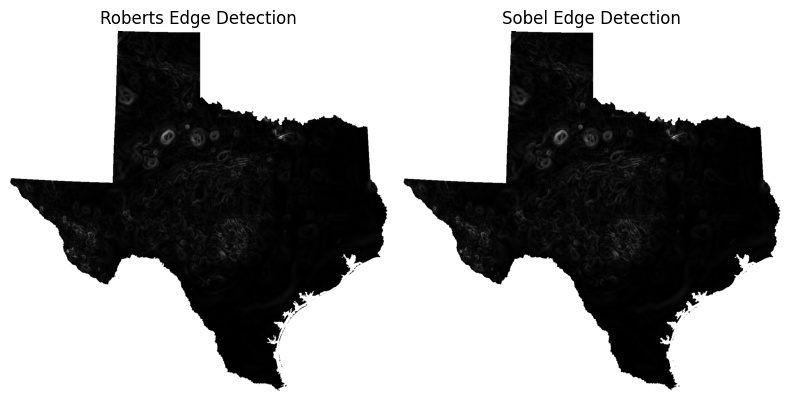

In [ ]:
from skimage import filters
from skimage.util import compare_images


image = masked_image.copy()
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Multi-Otsu Thresholding

The image here is Landsat SWIR imagery, band 7, of the uyuni Salt Flats in Bolivia. The salt flats are darker, with the Uyuni in the middle/bottom and a different salt flat in the top left. Multi-Otsu thresholding looks at the histogram of data and sets labels to specific data ranges. The salt flats in this imagery have a distinct set of values and are easily classified by the thresholding. This classification technique could be helpful for generating training data for a classification model.

https://earthexplorer.usgs.gov/

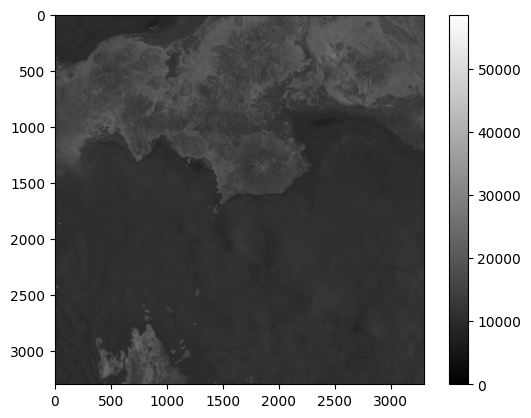

In [ ]:
with rasterio.open(raster_files[2]) as src:
    window = rasterio.windows.Window.from_slices((100,3400),(100,3400))
    image = src.read(1, window=window)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show()

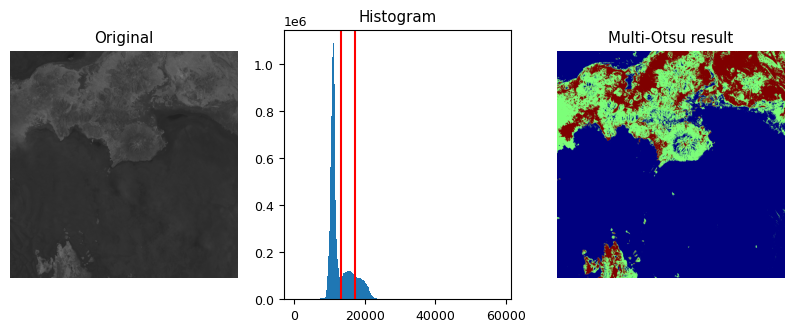

In [ ]:
from skimage.filters import threshold_multiotsu
import matplotlib

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9


# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

### GLCM Texture Features

The image here is a close shot of quartz being covered by goethite. The image is hosted on Mindat. GLCM texture features uses co-occurance matrices to show how patches occur in feature space. This example shows the different goethite patches are similar and training examples can be developed to classify patches in new images.

https://www.mindat.org/photo-1411863.html

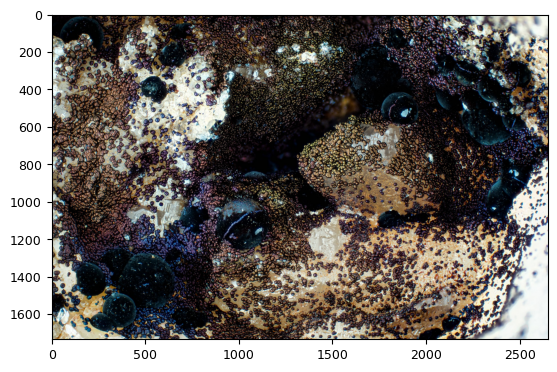

In [36]:
minerals = Image.open(jpg_files[1])
minerals_gray = minerals.convert('L')
minerals_array = np.array(minerals_gray)
image = minerals_array.copy()
plt.imshow(minerals)
plt.show()

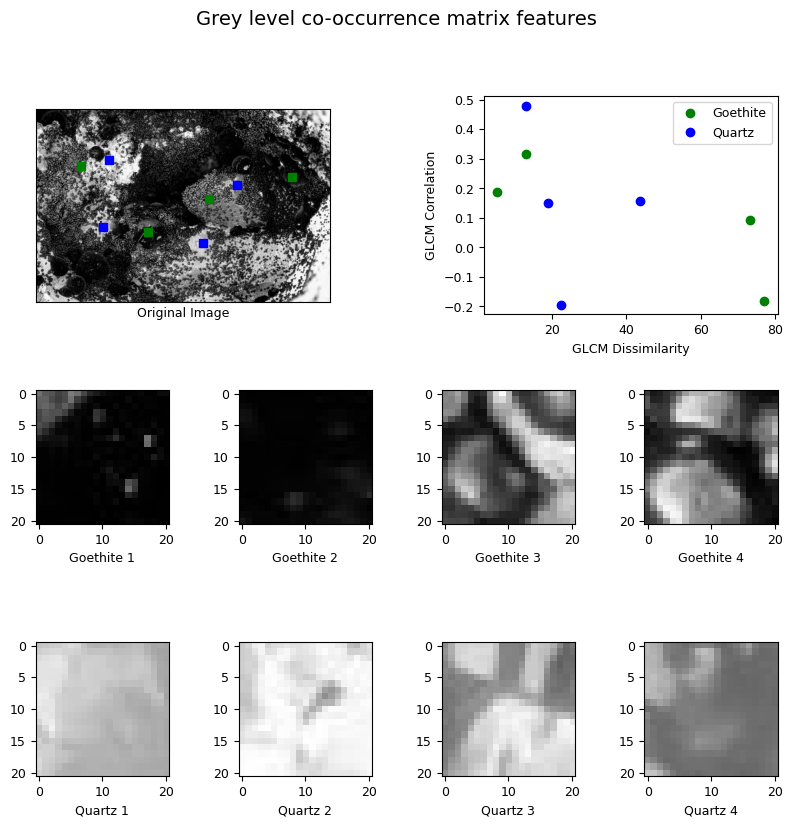

In [57]:
from skimage.feature import graycomatrix, graycoprops
from skimage import data


PATCH_SIZE = 21


# select some patches from grassy areas of the image
goe_locations = [(1100,1000), (600,2300), (500,400), (800,1550)]
goe_patches = []
for loc in goe_locations:
    goe_patches.append(
        image[loc[0] : loc[0] + PATCH_SIZE, loc[1] : loc[1] + PATCH_SIZE]
    )

# select some patches from sky areas of the image
q_locations = [(1200,1500), (450,650), (1050,600), (675,1800)]
q_patches = []
for loc in q_locations:
    q_patches.append(
        image[loc[0] : loc[0] + PATCH_SIZE, loc[1] : loc[1] + PATCH_SIZE]
    )

# compute some GLCM properties each patch
xs = []
ys = []
for patch in goe_patches + q_patches:
    glcm = graycomatrix(
        patch, distances=[5], angles=[0], levels=256, symmetric=True, normed=True
    )
    xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(graycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255)
for y, x in goe_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for y, x in q_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[: len(goe_patches)], ys[: len(goe_patches)], 'go', label='Goethite')
ax.plot(xs[len(q_patches) :], ys[len(q_patches) :], 'bo', label='Quartz')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(goe_patches):
    ax = fig.add_subplot(3, len(goe_patches), len(goe_patches) * 1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
    ax.set_xlabel(f"Goethite {i + 1}")

for i, patch in enumerate(q_patches):
    ax = fig.add_subplot(3, len(q_patches), len(q_patches) * 2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
    ax.set_xlabel(f"Quartz {i + 1}")


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### Reflection

The edge detction methods were my favorite. They have clear use cases for both regular and geospatial imagery. GLCM seems good for helping to create training data but the process seems tedious especially to develop a large training sample. Thresholding was interesting but using the data scientists judgement to create threshold values may be just as effective. Finally entropy was also an interesting tool to use and did well delineating the lava pool while ignoring the surrounding thermal noise. I'll very likely use edge operators in the future and the others will stay in the back of mind in case they may be useful.